# **Análisis de Severidad KPPS: Configuración Inicial**

Para evaluar la carga de dolor en los pacientes de la cohorte ReMePARK, necesitamos acceder a los datos que limpiamos y unificamos previamente. Este script comienza estableciendo el puente entre el entorno de procesamiento (Colab) y el almacenamiento en la nube.

# **Montaje de la Unidad (Google Drive)**
El siguiente comando importa la librería del sistema y solicita los permisos necesarios para leer y escribir archivos en tu Google Drive personal.

In [ ]:
from google.colab import drive

# Monta la unidad de Google Drive en el directorio local /content/drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Importación de Librerías y Dependencias**

Para llevar a cabo el cálculo de los dominios de severidad de la escala KPPS y su posterior visualización, necesitamos cargar un conjunto de herramientas estándar en análisis de datos.

**Carga de Módulos**

Ejecutamos la importación de los siguientes paquetes:

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

**Desglose de herramientas:**

**Manipulación de Datos (pandas, numpy):** Serán el motor principal. pandas nos permitirá manejar la base de datos como un DataFrame estructurado, mientras que numpy nos ayudará a realizar sumas vectorizadas para calcular los puntajes totales de cada dominio.

**Visualización (matplotlib, seaborn):** Indispensables para esta etapa. Una vez calculada la severidad, usaremos estas librerías para crear gráficos de caja (boxplots) que nos permitan comparar qué dominios de dolor son más intensos en la población.

**Gestión de Archivos (os, glob):** Útiles para navegar en las carpetas de Drive y gestionar rutas de archivos de manera robusta.

**Expresiones Regulares (re):** Muy útil si necesitamos buscar patrones específicos en los nombres de las columnas (por ejemplo, identificar todas las columnas que empiecen por "KPSS_" o "KPPS_").

# **Carga del Dataset Pre-procesado**

Para realizar el cálculo de severidad, partimos de la base de datos que ya ha sido limpiada y filtrada previamente. Esto garantiza que trabajamos con una cohorte válida y que los cálculos no se verán afectados por filas vacías o inconsistentes.

**Lectura del Archivo**

Definimos la ruta al archivo Remepark_cleaned_kpss.xlsx y lo cargamos en memoria.





In [ ]:
# 1. Definir ruta del archivo fuente
# Nota: Asegurarse de que esta ruta apunte al archivo generado en la fase de limpieza
file_path = '/content/drive/MyDrive/LCEN/08_Bases de Datos y Herramientas/08.2_ReMePARK/08.2.6_Unified ReMePARK 2024/Notebooks/Remepark_cleaned_kpss.xlsx'

# 2. Cargar archivo Excel en un DataFrame
df = pd.read_excel(file_path)

# 3. Visualizar las primeras 5 filas para verificar la carga correcta
df.head()

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
0,4170,2022,5/17/2022,1,1,100000,0,0,0,0,...,34.375,42.5,25.000000,33.333333,0.00,0.0,12.50,25.0,33.333333,21.458333
1,4475,2022,4/27/2022,1,1,100208,1,1,1,1,...,15.625,10.0,25.000000,12.500000,0.00,0.0,25.00,25.0,8.333333,13.229167
2,3509,2020,2020-06-02 00:00:00,1,1,100235,0,0,0,0,...,9.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4537,2023,8/14/2023,10,9,104248,1,1,1,1,...,31.250,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833
4,4538,2024,2024-02-12 00:00:00,10,10,104248,1,0,0,0,...,25.000,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167


# **Filtrado de Registros por Visitas Acumuladas**

Para centrar el análisis en el seguimiento o en pacientes con historial previo, aplicamos un filtro para excluir las filas correspondientes a la primera visita registrada (o aquellas con un contador acumulado igual a 1).

**Exclusión de Registros Iniciales**

El siguiente código genera un nuevo DataFrame (df_filtered) conservando únicamente las filas donde la variable accum.visits_kpps es mayor estrictamente a 1.

In [ ]:
# 1. Aplicación del filtro numérico
# Se seleccionan las filas donde el acumulado de visitas es mayor a 1
# .copy() se usa para asegurar que 'df_filtered' sea un objeto independiente y no una vista
df_filtered = df[df['accum.visits_kpps'] > 1].copy()

# 2. Verificación del resultado
# Mostramos las primeras filas para confirmar que los valores de 'accum.visits_kpps' comienzan en 2 o más
display(df_filtered.head())

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
3,4537,2023,8/14/2023,10,9,104248,1,1,1,1,...,31.25,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833
4,4538,2024,2024-02-12 00:00:00,10,10,104248,1,0,0,0,...,25.00,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167
5,4362,2022,2022-03-03 00:00:00,3,2,113193,2,2,4,4,...,18.75,7.5,0.000000,25.000000,0.00,0.0,18.75,0.0,25.000000,9.531250
6,4363,2024,2/15/2024,3,3,113193,1,1,1,1,...,31.25,30.0,12.500000,25.000000,18.75,0.0,18.75,0.0,33.333333,17.291667
7,4555,2021,10/18/2021,3,2,129131,0,0,0,0,...,6.25,22.5,12.500000,0.000000,0.00,0.0,12.50,0.0,0.000000,5.937500


# **Estandarización Temporal: Conversión a Datetime**

Para realizar cálculos de intervalos temporales (tiempo transcurrido entre visitas), es obligatorio asegurarse de que la variable de fecha tenga el formato correcto. A menudo, al importar desde Excel, las fechas se leen como texto (object), lo que impide realizar operaciones aritméticas con ellas.

**Transformación de Tipos de Datos**

El siguiente código convierte la columna fecha.eval_kpps al formato estándar de fecha de Pandas (datetime64).


In [ ]:
# 1. Conversión a objeto Datetime
# Utilizamos 'pd.to_datetime' para interpretar las cadenas de texto como fechas.
# errors='coerce': Si encuentra una fecha inválida (ej. "sin fecha"), la convierte en NaT (Not a Time) en lugar de romper el código.
df_filtered['fecha.eval_kpps'] = pd.to_datetime(df_filtered['fecha.eval_kpps'], errors='coerce')

# 2. Verificación de Tipos
# .info() nos permite auditar si la columna cambió exitosamente de 'object' a 'datetime64[ns]'
display(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 3 to 1049
Columns: 312 entries, Consecutivo to PDQ39.SI.index
dtypes: datetime64[ns](2), float64(186), int64(114), object(10)
memory usage: 2.1+ MB


None

**Por qué es importante este paso:**

**Aritmética de Fechas:** Solo con el formato datetime podemos ejecutar operaciones como Fecha_Visita_2 - Fecha_Visita_1.

**Manejo de Errores (coerce):** Bases de datos clínicas reales suelen tener errores de tipeo. Este parámetro asegura que esos errores se gestionen como valores nulos (NaT) de forma segura, permitiendo identificarlos y filtrarlos si es necesario.

# **Ordenamiento Cronológico y por Sujeto**

Antes de calcular intervalos de tiempo entre visitas, es imprescindible organizar la estructura de los datos. Necesitamos que las filas estén agrupadas por paciente y, dentro de cada paciente, ordenadas de la visita más antigua a la más reciente.

**Algoritmo de Ordenamiento**

El siguiente código utiliza sort_values para reorganizar el DataFrame basándose en dos claves jerárquicas:

**reg.innn (Prioridad 1):** Agrupa todas las filas de un mismo paciente.

**fecha.eval_kpps (Prioridad 2):** Ordena las visitas cronológicamente dentro de cada bloque de paciente.


**Reasoning**:
Sort the dataframe by subject ID and then by date to prepare for calculating time differences between consecutive visits.



In [ ]:
# 1. Ejecución del ordenamiento
# ascending=[True, True] asegura un orden ascendente (A-Z, Antiguo-Reciente) para ambas columnas.
df_filtered = df_filtered.sort_values(by=['reg.innn', 'fecha.eval_kpps'], ascending=[True, True])

# 2. Verificación visual
# Al mostrar el head(), deberíamos ver al mismo sujeto repetido en filas consecutivas
# con sus fechas avanzando progresivamente.
display(df_filtered.head())

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
3,4537,2023,2023-08-14,10,9,104248,1,1,1,1,...,31.25,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833
4,4538,2024,2024-02-12,10,10,104248,1,0,0,0,...,25.00,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167
5,4362,2022,2022-03-03,3,2,113193,2,2,4,4,...,18.75,7.5,0.000000,25.000000,0.00,0.0,18.75,0.0,25.000000,9.531250
6,4363,2024,2024-02-15,3,3,113193,1,1,1,1,...,31.25,30.0,12.500000,25.000000,18.75,0.0,18.75,0.0,33.333333,17.291667
7,4555,2021,2021-10-18,3,2,129131,0,0,0,0,...,6.25,22.5,12.500000,0.000000,0.00,0.0,12.50,0.0,0.000000,5.937500


**Por qué es crucial:**

Si los datos no están ordenados, al usar funciones de desplazamiento (como .shift() en el siguiente paso), podríamos estar restando la fecha de la Visita 1 del Paciente B menos la Visita 5 del Paciente A, generando datos de tiempo negativos o absurdos ("basura lógica").

# **Cálculo de Intervalos Temporales (Time Delta)**

Una vez que los datos están ordenados cronológicamente por sujeto, podemos calcular el tiempo exacto que ha transcurrido entre una visita y la siguiente. Esto es fundamental para determinar la frecuencia de seguimiento y validar si los intervalos entre evaluaciones son consistentes.

**Ejecución del Cálculo Diferencial**

El siguiente código agrupa los datos por paciente y aplica la función de diferenciación sobre la columna de fechas.

In [ ]:
# 1. Cálculo de la diferencia (Delta T)
# groupby('reg.innn'): Aísla el historial de cada paciente para que el cálculo no mezcle sujetos.
# .diff(): Resta el valor de la fila actual menos el valor de la fila anterior (Visit_N - Visit_N-1).
df_filtered['time_difference'] = df_filtered.groupby('reg.innn')['fecha.eval_kpps'].diff()

# 2. Verificación de resultados
display(df_filtered.head())

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index,time_difference
3,4537,2023,2023-08-14,10,9,104248,1,1,1,1,...,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833,NaT
4,4538,2024,2024-02-12,10,10,104248,1,0,0,0,...,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167,182 days
5,4362,2022,2022-03-03,3,2,113193,2,2,4,4,...,7.5,0.000000,25.000000,0.00,0.0,18.75,0.0,25.000000,9.531250,NaT
6,4363,2024,2024-02-15,3,3,113193,1,1,1,1,...,30.0,12.500000,25.000000,18.75,0.0,18.75,0.0,33.333333,17.291667,714 days
7,4555,2021,2021-10-18,3,2,129131,0,0,0,0,...,22.5,12.500000,0.000000,0.00,0.0,12.50,0.0,0.000000,5.937500,NaT


**Análisis de la Lógica:**

Aislamiento por groupby: Es crítico. Si no agrupamos por reg.innn, al terminar las visitas del Paciente A y empezar las del Paciente B, el código restaría la fecha de B menos la de A, generando un dato erróneo. El agrupamiento asegura que el cálculo se reinicie para cada nuevo paciente.

**Resultado NaN (NaT):**

Para la primera visita de cada paciente, el resultado será NaT (Not a Time) o nulo.

Esto es correcto y esperado, ya que no existe una "visita previa" contra la cual restar.

**Tipo de Dato:** La nueva columna time_difference será de tipo timedelta64 (ej. 365 days 00:00:00), lo cual permite extraer fácilmente los días, meses o años posteriormente.

# **Análisis Longitudinal: Definición de Baseline y Endpoint**

Para evaluar la progresión de la severidad del dolor (KPSS.TOTAL), comparamos el estado inicial del paciente contra su última evaluación disponible. Este enfoque nos permite calcular el cambio neto a lo largo del periodo de seguimiento.

**Selección de Puntos de Corte Temporal**

Dado que los datos ya fueron ordenados cronológicamente en el paso anterior, podemos extraer fácilmente la primera y la última fila de cada paciente para crear dos sub-cohortes: "Inicio" y "Final".

In [ ]:
# 1. Extracción de la Visita Basal (Baseline / T0)
# Agrupamos por paciente y tomamos el primer registro cronológico.
# .reset_index() es vital para recuperar 'reg.innn' como columna y no como índice.
df_first_visit = df_filtered.groupby('reg.innn').first().reset_index()

# 2. Extracción de la Visita Final (Endpoint / Tn)
# Tomamos el último registro disponible para cada sujeto.
df_last_visit = df_filtered.groupby('reg.innn').last().reset_index()

# 3. Verificación de las Sub-cohortes
print("--- Visitas Basales (Muestra) ---")
display(df_first_visit.head())

print("\n--- Visitas Finales (Muestra) ---")
display(df_last_visit.head())

,reg.innn,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index,time_difference
0,104248,4537,2023,2023-08-14,10,9,1,1,1,1,...,37.5,29.166667,41.666667,31.25,50.0,31.25,50.000000,33.333333,38.020833,182 days
1,113193,4362,2022,2022-03-03,3,2,2,2,4,4,...,7.5,0.000000,25.000000,0.00,0.0,18.75,0.000000,25.000000,9.531250,714 days
2,129131,4555,2021,2021-10-18,3,2,0,0,0,0,...,22.5,12.500000,0.000000,0.00,0.0,12.50,0.000000,0.000000,5.937500,791 days
3,133232,1756,2019,2019-02-14,8,7,0,0,0,0,...,90.0,83.333333,29.166667,6.25,0.0,18.75,33.333333,58.333333,39.895833,1236 days
4,143927,2424,2019,2019-03-13,11,7,0,0,0,0,...,17.5,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,2.187500,771 days


,reg.innn,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index,time_difference
0,104248,4538,2024,2024-02-12,10,10,1,0,0,0,...,80.0,62.500000,8.333333,18.75,0.0,6.25,0.000000,0.000000,21.979167,182 days
1,113193,4363,2024,2024-02-15,3,3,1,1,1,1,...,30.0,12.500000,25.000000,18.75,0.0,18.75,0.000000,33.333333,17.291667,714 days
2,129131,4554,2023,2023-12-18,3,3,0,0,0,0,...,20.0,0.000000,4.166667,0.00,0.0,0.00,0.000000,8.333333,4.062500,791 days
3,133232,4393,2022,2022-07-04,8,8,1,1,1,1,...,90.0,83.333333,29.166667,6.25,0.0,18.75,33.333333,58.333333,39.895833,1236 days
4,143927,4519,2024,2024-03-25,11,11,0,0,0,0,...,17.5,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,2.187500,1068 days


**Lógica del Procedimiento:**

groupby('reg.innn'): Divide el DataFrame gigante en "mini-tablas", una por paciente.

.first() y .last():

Como ordenamos por fecha previamente, .first() garantiza que estamos tomando la visita más antigua registrada.

.last() toma la más reciente.

**Nota:** Si un paciente solo tiene 2 visitas, la primera es Baseline y la segunda es Endpoint. Si tiene 10 visitas, ignoramos las intermedias (2 a 9) y nos centramos en el cambio total (1 vs 10).

# **Análisis de la Variable Categórica: Severidad del Dolor**

Además del puntaje numérico total (variable continua), es clínicamente relevante clasificar a los pacientes en Niveles de Severidad (Categorías). Este bloque de código realiza una búsqueda heurística dentro del DataFrame para identificar si ya existe una columna que contenga esta clasificación (etiquetada comúnmente como "Severity", "Class", "Grade" o "Stage").

**Algoritmo de Búsqueda y Exploración**

El script itera sobre las columnas del DataFrame buscando palabras clave específicas. Si no encuentra una coincidencia exacta, despliega un reporte de "sospechosos habituales" (columnas con pocos valores únicos) para que el investigador identifique la variable visualmente.

In [ ]:
# 1. Inicialización de la búsqueda
kpss_severity_col = None

# 2. Iteración sobre todas las columnas
for col in df_filtered.columns:
    # Estrategia A: Búsqueda por palabras clave explícitas (Severity, Class)
    # Se combinan con 'KPSS' para evitar confundirse con la severidad de otra escala.
    if 'KPSS' in col and any(keyword in col for keyword in ['Severity', 'SEVERITY', 'severity', 'Class', 'CLASS', 'class']):
        kpss_severity_col = col
        break

    # Estrategia B: Búsqueda por términos alternativos (Level, Grade, Stage)
    if 'KPSS' in col and any(keyword in col for keyword in ['Level', 'LEVEL', 'level', 'Grade', 'grade', 'Stage', 'stage']):
         kpss_severity_col = col
         break

# 3. Ejecución de Resultados
if kpss_severity_col:
    # ESCENARIO 1: Éxito
    print(f"✅ Se encontró una columna potencial de severidad: '{kpss_severity_col}'")
    # Mostramos la distribución de frecuencias (Cuántos leves, moderados, etc.)
    display(df_filtered[kpss_severity_col].value_counts())
else:
    # ESCENARIO 2: No encontrado (Fallback)
    print("⚠️ No se encontró una columna con nombre explícito de severidad.")

    # Plan B: Mostrar todas las columnas de KPSS que parezcan categóricas
    # Criterio: Ser texto (object) o tener menos de 20 valores únicos (baja cardinalidad).
    print("Explorando columnas KPSS con potencial categórico:")
    kpss_cols = [col for col in df_filtered.columns if 'KPSS' in col]

    for col in kpss_cols:
        if df_filtered[col].dtype == 'object' or df_filtered[col].nunique() < 20:
             print(f"\nConteo de valores para: '{col}'")
             display(df_filtered[col].value_counts().head())

Found a potential KPSS severity column: 'KPSS Severity'


,count
KPSS Severity,
No pain,428
Mild pain,379
Moderate pain,76
Severe pain,3


# **Preparación de Datos para Análisis Categórico (Severidad KPPS)**

Para analizar cómo transitan los pacientes entre los diferentes niveles de severidad a lo largo del tiempo (por ejemplo, cuántos pacientes pasaron de "Leve" a "Moderado"), construimos un sub-dataset específico y optimizado para este propósito.

**Depuración y Ordenamiento**

El siguiente bloque de código realiza cuatro acciones críticas:

Selección de Variables: Aísla únicamente las columnas necesarias (ID, Fecha, Severidad) para reducir el ruido.

Estandarización Temporal: Re-confirma el formato de fecha para asegurar el orden cronológico.

Ordenamiento Jerárquico: Organiza los datos por paciente y fecha (fundamental para definir "Origen" y "Destino" en las transiciones).

Limpieza Estricta: Elimina cualquier fila donde falte la clasificación de severidad, ya que no podemos analizar una transición si desconocemos el estado en algún punto.


In [ ]:
# 1. Creación del Sub-Dataset
# Seleccionamos solo las 3 columnas vitales y usamos .copy() para trabajar en memoria independiente.
df_kpss_severity = df_filtered[['reg.innn', 'fecha.eval_kpps', 'KPSS Severity']].copy()

# 2. Validación de Fecha
# Aunque ya se hizo antes, es buena práctica re-asegurar el formato datetime aquí
# para evitar errores si este bloque se ejecuta aisladamente.
df_kpss_severity['fecha.eval_kpps'] = pd.to_datetime(df_kpss_severity['fecha.eval_kpps'], errors='coerce')

# 3. Ordenamiento Cronológico
# Ascendente por ID (reg.innn) y luego por Fecha. Esto alinea la historia clínica de cada paciente.
df_kpss_severity = df_kpss_severity.sort_values(by=['reg.innn', 'fecha.eval_kpps'], ascending=[True, True])

# 4. Eliminación de Datos Faltantes
# Si no sabemos la severidad en una visita, esa visita no sirve para el análisis de transición.
df_kpss_severity.dropna(subset=['KPSS Severity'], inplace=True)

# 5. Verificación de Resultados
print("--- Primeras filas del dataset de severidad preparado ---")
display(df_kpss_severity.head())

print("\n--- Auditoría de valores nulos restantes ---")
# El resultado esperado es 0.
display(df_kpss_severity['KPSS Severity'].isnull().sum())

,reg.innn,fecha.eval_kpps,KPSS Severity
3,104248,2023-08-14,Mild pain
4,104248,2024-02-12,Mild pain
5,113193,2022-03-03,Mild pain
6,113193,2024-02-15,Mild pain
7,129131,2021-10-18,No pain



Missing values in 'KPSS Severity' after dropping:


np.int64(0)

# **Análisis de Cambio Categórico:**

**Evolución de la Severidad**

Para evaluar la estabilidad o progresión de los estadios clínicos del dolor (Severidad KPPS) entre el inicio y el final del seguimiento, utilizamos tablas de contingencia y pruebas de simetría.

Dado que la variable de severidad suele tener más de dos niveles (ej. Leve, Moderado, Severo), la prueba estadística adecuada es el Test de Simetría de Bowker (una generalización del Test de McNemar para tablas $k \times k$).

**1. Preparación de Datos Pareados**

Primero, aislamos a los pacientes que tienen al menos dos visitas y reestructuramos los datos para tener el estado "Inicial" y "Final" en la misma fila (Formato Wide).


In [ ]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# 1. Identificación de la Cohorte Pareada
# Contamos cuántas visitas tiene cada sujeto en el dataset de severidad
subject_visit_counts = df_kpss_severity['reg.innn'].value_counts()
subjects_multiple_visits = subject_visit_counts[subject_visit_counts >= 2].index

# Filtramos para quedarnos solo con estos sujetos
df_multiple_visits = df_kpss_severity[df_kpss_severity['reg.innn'].isin(subjects_multiple_visits)].copy()

# 2. Extracción de Estados: Inicio vs. Fin
# Obtenemos la primera clasificación registrada
df_first_visit_severity = df_multiple_visits.groupby('reg.innn').first().reset_index()
# Obtenemos la última clasificación registrada
df_last_visit_severity = df_multiple_visits.groupby('reg.innn').last().reset_index()

# 3. Fusión de Estados (Wide Format)
# Unimos ambas tablas para comparar directamente 'Severity_first' vs 'Severity_last'
df_comparison = pd.merge(df_first_visit_severity[['reg.innn', 'KPSS Severity']],
                         df_last_visit_severity[['reg.innn', 'KPSS Severity']],
                         on='reg.innn',
                         suffixes=('_first', '_last'))

Contingency Table (First Visit Severity vs Last Visit Severity):


KPSS Severity_last,Mild pain,Moderate pain,No pain,Severe pain
KPSS Severity_first,,,,
Mild pain,50,8,33,0
Moderate pain,10,3,6,1
No pain,63,9,77,0



Contingency Table (Reindexed for Bowker's Test):


KPSS Severity_last,Mild pain,Moderate pain,No pain,Severe pain
KPSS Severity_first,,,,
Mild pain,50,8,33,0
Moderate pain,10,3,6,1
No pain,63,9,77,0
Severe pain,0,0,0,0



Bowker's test (generalized McNemar's test) for change in KPSS Severity between first and last visit:
Statistic: 0.05555555555555555
P-value: 0.8136637157667919
There is no statistically significant change in KPSS Severity between the first and last visit (fail to reject H0)


**2. Generación de la Tabla de Contingencia**

Creamos una matriz cuadrada donde las filas representan la severidad inicial y las columnas la severidad final.

Diagonal Principal: Pacientes que se mantuvieron en el mismo nivel.

Fuera de la Diagonal: Pacientes que mejoraron o empeoraron.

In [ ]:
# 1. Creación de Tabla Cruzada (Crosstab)
contingency_table = pd.crosstab(df_comparison['KPSS Severity_first'],
                                df_comparison['KPSS Severity_last'])

print("Tabla de Contingencia Original:")
display(contingency_table)

# 2. Estandarización de la Tabla (Requisito para el Test de Bowker)
# El test requiere una matriz perfectamente cuadrada (mismas categorías en filas y columnas).
# Si, por ejemplo, nadie terminó en estado "Severo", esa columna faltaría y el test fallaría.

# Obtenemos todos los niveles posibles presentes en los datos
all_severity_levels = sorted(list(set(df_comparison['KPSS Severity_first'].unique()) |
                                  set(df_comparison['KPSS Severity_last'].unique())))

# Reindexamos la tabla llenando con 0 las categorías faltantes
contingency_table_reindexed = contingency_table.reindex(index=all_severity_levels,
                                                        columns=all_severity_levels,
                                                        fill_value=0)

print("\nTabla de Contingencia Estandarizada (Lista para Test):")
display(contingency_table_reindexed)

**3. Ejecución del Test de Bowker (McNemar Generalizado)**

Evaluamos la hipótesis de simetría:

$H_0$ (Simetría): La probabilidad de cambiar de la categoría $A \rightarrow B$ es la misma que cambiar de $B \rightarrow A$. (Los cambios son aleatorios o equilibrados).

$H_1$ (Asimetría): Existe una dirección predominante en el cambio (ej. significativamente más pacientes empeoran que los que mejoran).

In [ ]:
# Verificamos que la tabla sea válida (cuadrada y mayor a 1x1)
if contingency_table_reindexed.shape[0] > 1 and contingency_table_reindexed.shape[0] == contingency_table_reindexed.shape[1]:

    # Ejecutamos McNemar (con exact=False para usar aproximación Chi-cuadrado, que equivale a Bowker en tablas > 2x2)
    result = mcnemar(contingency_table_reindexed, exact=False)

    print("\nResultados del Test de Bowker (Cambio de Severidad):")
    print(f"Estadístico Chi2: {result.statistic:.4f}")
    print(f"P-value:          {result.pvalue:.4e}")

    # Interpretación
    alpha = 0.05
    if result.pvalue > alpha:
        print("❌ P > 0.05: No hay cambio asimétrico significativo (Estabilidad Categórica).")
    else:
        print("✅ P < 0.05: Existe un cambio significativo en la distribución de severidad (Evolución Categórica).")
else:
    print("⚠️ No se puede realizar el test: La tabla no es cuadrada o solo hay una categoría.")

**Guía de Interpretación Clínica:**

Mirar la Diagonal:

¿La mayoría de los pacientes están en la diagonal (ej. Leve $\rightarrow$ Leve)? Si es así, la condición es estable.

Mirar los Triángulos:Si el triángulo superior derecho (ej. Leve $\rightarrow$ Moderado) tiene números mucho más altos que el triángulo inferior izquierdo (Moderado $\rightarrow$ Leve), la enfermedad está progresando.

El Test de Bowker te confirma matemáticamente si ese desbalance es real o casualidad.

# **Distribución de Severidad:**

Línea Base vs. SeguimientoPara complementar el análisis de transición, calculamos las frecuencias absolutas y relativas de los niveles de severidad (Leve, Moderado, Severo) en el momento inicial y final. Esto nos da una "foto panorámica" de cómo cambió la estructura de la cohorte.

**Cálculo de Frecuencias y Porcentajes**

El siguiente código utiliza la tabla pareada df_comparison (generada en el paso anterior) para asegurar que estamos comparando exactamente a los mismos pacientes en ambos momentos ($N$ constante).

In [ ]:
# -----------------------------------------------------------
# 1. Análisis del Momento Inicial (Baseline / First Visit)
# -----------------------------------------------------------
print("Descriptive Statistics for KPSS Severity at Baseline (First Visit):")

# Frecuencia Absoluta (Conteo de pacientes)
baseline_severity_counts = df_comparison['KPSS Severity_first'].value_counts()

# Frecuencia Relativa (Porcentaje)
# normalize=True convierte el conteo a fracción (0-1). Multiplicamos por 100 para %
baseline_severity_percentages = df_comparison['KPSS Severity_first'].value_counts(normalize=True) * 100

print("\nCounts (Baseline):")
display(baseline_severity_counts)
print("\nPercentages (Baseline):")
display(baseline_severity_percentages)

# -----------------------------------------------------------
# 2. Análisis del Momento Final (Follow-up / Last Visit)
# -----------------------------------------------------------
print("\nDescriptive Statistics for KPSS Severity at Follow-up (Last Visit):")

# Frecuencia Absoluta
followup_severity_counts = df_comparison['KPSS Severity_last'].value_counts()

# Frecuencia Relativa
followup_severity_percentages = df_comparison['KPSS Severity_last'].value_counts(normalize=True) * 100

print("\nCounts (Follow-up):")
display(followup_severity_counts)
print("\nPercentages (Follow-up):")
display(followup_severity_percentages)

Descriptive Statistics for KPSS Severity at Baseline (First Visit):

Counts:


,count
KPSS Severity_first,
No pain,149
Mild pain,91
Moderate pain,20



Percentages:


,proportion
KPSS Severity_first,
No pain,57.307692
Mild pain,35.000000
Moderate pain,7.692308



Descriptive Statistics for KPSS Severity at Follow-up (Last Visit):

Counts:


,count
KPSS Severity_last,
Mild pain,123
No pain,116
Moderate pain,20
Severe pain,1



Percentages:


,proportion
KPSS Severity_last,
Mild pain,47.307692
No pain,44.615385
Moderate pain,7.692308
Severe pain,0.384615


**Guía de Interpretación de Resultados:**


Al comparar las dos tablas resultantes, busca las siguientes tendencias:

Desplazamiento de la Carga: ¿Disminuyó el porcentaje de pacientes en la categoría "Mild" (Leve)? Si es así, ¿a dónde se fueron?

**Consistencia del N:** La suma de los conteos (Counts) debe ser idéntica en Baseline y Follow-up. Si difieren, hubo un error en la creación de df_comparison.

**Reporte Clínico:** Estos son los números que escribirás en el texto de resultados.

Ejemplo: "Al inicio, el 40% (n=20) presentaba dolor severo, cifra que aumentó al 55% (n=27) en la última visita."

# **Visualización de Cambios: Distribución y Transición de Severidad**


Para comunicar efectivamente los hallazgos sobre la evolución de la severidad del dolor, generamos dos tipos de representaciones gráficas complementarias.

**Gráfico de Barras Agrupadas:** Permite comparar visualmente la prevalencia de cada estadio (Leve, Moderado, Severo) al inicio vs. al final.

**Mapa de Calor (Heatmap):** Representa gráficamente la matriz de transición, facilitando la identificación de patrones de cambio (ej. qué tan común es que un paciente empeore).

**1. Gráfico de Barras Comparativo (Side-by-Side)**
Para este gráfico, necesitamos transformar los datos de un formato ancho (wide) a uno largo (long), donde cada fila represente una visita única de un paciente.

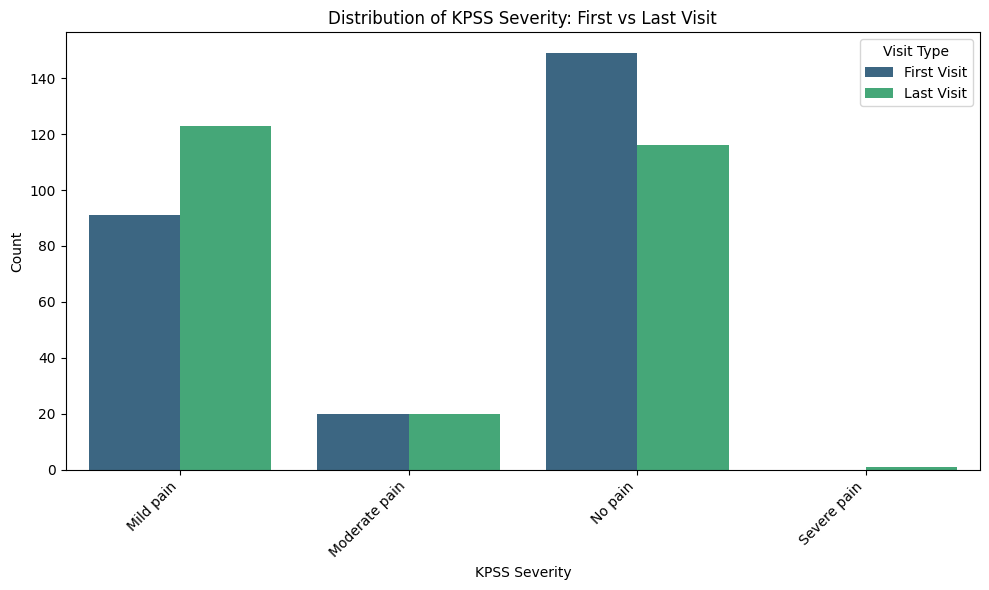

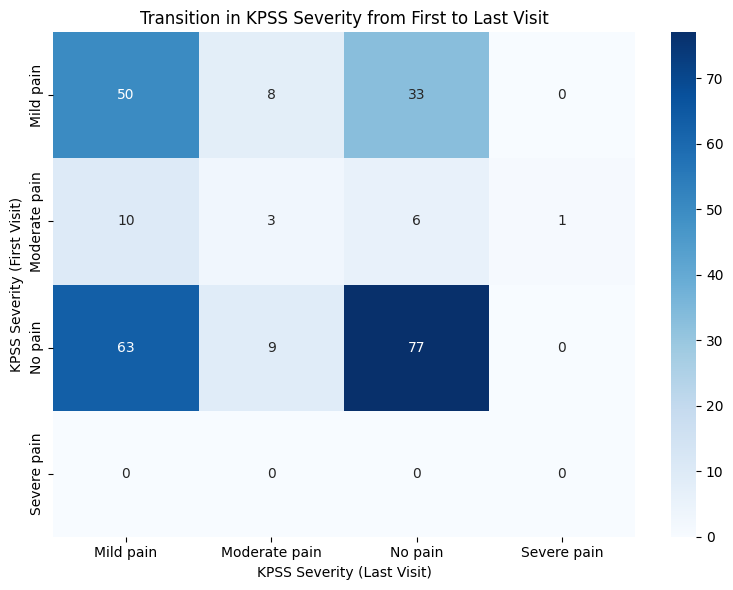

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# Paso 1: Transformación de Datos (Melting)
# ---------------------------------------------------------
# Convertimos las columnas 'Severity_first' y 'Severity_last' en una sola columna vertical
# Esto es necesario para que Seaborn pueda agrupar por 'Visit Type'.
df_melted = df_comparison.melt(id_vars='reg.innn',
                               value_vars=['KPSS Severity_first', 'KPSS Severity_last'],
                               var_name='Visit Type',
                               value_name='KPSS Severity')

# Renombramos las etiquetas para que el gráfico sea legible
df_melted['Visit Type'] = df_melted['Visit Type'].replace({
    'KPSS Severity_first': 'First Visit (Baseline)',
    'KPSS Severity_last': 'Last Visit (Follow-up)'
})

# ---------------------------------------------------------
# Paso 2: Generación del Gráfico de Barras
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# sns.countplot cuenta automáticamente las frecuencias
sns.countplot(data=df_melted,
              x='KPSS Severity',
              hue='Visit Type',
              palette='viridis',
              order=all_severity_levels) # Usamos el orden guardado previamente para consistencia

plt.title('Distribución de Severidad KPSS: Inicio vs. Final', fontsize=14)
plt.xlabel('Nivel de Severidad', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)
plt.legend(title='Momento de Evaluación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**2. Mapa de Calor de Transiciones (Matriz de Confusión)**

Este gráfico colorea la tabla de contingencia que calculamos en el paso del Test de Bowker. Es ideal para ver rápidamente dónde se concentra la mayor parte de la población.

In [ ]:
# ---------------------------------------------------------
# Paso 3: Generación del Heatmap
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))

# Usamos la tabla reindexada para asegurar que sea cuadrada
sns.heatmap(contingency_table_reindexed,
            annot=True,     # Escribe el número exacto dentro de cada celda
            fmt='d',        # Formato entero (decimal integer)
            cmap='Blues',   # Escala de azules (más oscuro = más pacientes)
            cbar=True)      # Barra de color lateral

plt.title('Matriz de Transición: Severidad KPSS (Inicio -> Final)', fontsize=14)
plt.xlabel('Severidad en la Última Visita', fontsize=12)
plt.ylabel('Severidad en la Primera Visita', fontsize=12)
plt.tight_layout()
plt.show()

**Guía de Interpretación Visual:**


**En el Gráfico de Barras:**

Si las barras del "Last Visit" son más altas en las categorías de la derecha (Severo/Moderado) que las del "First Visit", confirma visualmente el empeoramiento progresivo de la cohorte.

**En el Heatmap:**

Diagonal Oscura: Indica estabilidad (los pacientes se quedan donde empezaron).

Triángulo Superior Derecho Oscuro: Indica progresión de la enfermedad (movimiento hacia mayor severidad).

Triángulo Inferior Izquierdo Oscuro: Indica mejoría o remisión.

# **Selección de Variables Explicativas (Feature Screening)**

Para entender los determinantes del dolor en la enfermedad de Parkinson, definimos una lista de "variables candidatas" basada en el conocimiento clínico. Estas covariables se utilizarán posteriormente para buscar asociaciones con la escala KPPS.

**Definición y Filtrado de Covariables**


El siguiente código establece una lista teórica de factores de interés (Demográficos, Clínicos, Tratamiento y No Motores) y verifica cuáles de ellos están presentes físicamente en el DataFrame actual.

**Reasoning**:
Identify potential explanatory variables by examining the columns in the `df_filtered` DataFrame, focusing on demographics, clinical scores, and treatment information.



In [ ]:
# 1. Inspección inicial
# Imprimimos todas las columnas disponibles para tener un mapa completo de la base de datos
print("Columns in df_filtered:")
print(df_filtered.columns.tolist())

# 2. Definición de la Lista de Deseos (Domain Knowledge)
# Esta lista incluye factores que la literatura sugiere asociados al dolor en EP:
# - Demográficos: Edad, Sexo, Escolaridad.
# - Clínicos: Tiempo de evolución, Hoehn & Yahr, Fenotipo.
# - Farmacológicos: Dosis de Levodopa (LEDD), Agonistas.
# - Motores: UPDRS (Partes I, II, III, IV).
# - No Motores: Depresión, Ansiedad, Sueño, Cognición (MMSE).
potential_explanatory_vars = [
    'anio.eval_kpps', 'visit.numb', 'reg.innn', 'Edad', 'Sexo',
    'Anios.Escolaridad', 'Estado.Civil', 'Empleo', 'Dominancia',
    'Tiempo.evolucion.sintomas', 'Lado.inicio.sintomas', 'Historia.familiar.EP',
    'Uso.Levodopa', 'Dosis.Levodopa', 'Uso.Agonista', 'Uso.IMAOB',
    'Uso.ICOMT', 'Uso.Otros', 'Hoehn.Yahr', 'MMSE.Total', 'Escala.Sueno',
    'Fatiga', 'Estreñimiento', 'Hiposmia', 'Dolor', 'Apatia', 'Ansiedad',
    'Depresion', 'Alucinaciones.Visuales', 'Psicosis', 'Juego.patologico',
    'Hipersexualidad', 'Comer.compulsivo', 'Compras.compulsivas',
    'Otros.trastornos.control.impulsos', 'Demencia', 'Deterioro.cognitivo.leve',
    'EP.familiar', 'EP.inicio.temprano', 'EP.inicio.tardio', 'Tipo.fenotipico',
    'UPDRS1.Total', 'UPDRS2.Total', 'UPDRS3.Total', 'UPDRS4.Total', 'UPDRS.TOTAL',
    'PDQ8.index', 'PDQ39.mov.index', 'PDQ39.daily.index', 'PDQ39.Emotion.index',
    'PDQ39.stigma.index', 'PDQ39.social.index', 'PDQ39.cogni.index',
    'PDQ39.comm.index', 'PDQ39.discom.index', 'PDQ39.SI.index'
]

# 3. Validación de Existencia
# Filtramos la lista teórica para quedarnos solo con las columnas que REALMENTE existen en 'df_filtered'.
# Esto previene errores de tipo KeyError en pasos futuros.
present_explanatory_vars = [col for col in potential_explanatory_vars if col in df_filtered.columns]

# 4. Resultado
print("\nVariables explicativas confirmadas para el análisis:")
print(present_explanatory_vars)

Columns in df_filtered:
['Consecutivo', 'anio.eval_kpps', 'fecha.eval_kpps', 'accum.visits_kpps', 'visit.numb', 'reg.innn', 'KPSS1.F', 'KPSS1.S', 'KPSS1.TOT', 'KPSS.D1', 'KPSS2.F', 'KPSS2.S', 'KPSS2.TOT', 'KPSS3.F', 'KPSS3.S', 'KPSS3.TOT', 'KPSS.D2', 'KPSS4.F', 'KPSS4.S', 'KPSS4.TOT', 'KPSS5.F', 'KPSS5.S', 'KPSS5.TOT', 'KPSS6.F', 'KPSS6.S', 'KPSS6.TOT', 'KPSS.D3', 'KPSS7.F', 'KPSS7.S', 'KPSS7.TOT', 'KPSS8.F', 'KPSS8.S', 'KPSS8.TOT', 'KPSS.D4', 'KPSS9.F', 'KPSS9.S', 'KPSS9.TOT', 'KPSS10.F', 'KPSS10.S', 'KPSS10.TOT', 'KPSS11.F', 'KPSS11.S', 'KPSS11.TOT', 'KPSS.D5', 'KPSS12.F', 'KPSS12.S', 'KPSS12.TOT', 'KPSS13.S', 'KPSS13.F', 'KPSS13.TOT', 'KPSS.D6', 'KPSS14.F', 'KPSS14.S', 'KPSS14.TOT', 'KPSS.D7', 'KPSS.TOTAL', 'KPSS Severity', 'KPSS_Delta', 'MCID', 'num.consec', 'fila_id', 'anio.eval_sociodemograph', 'fecha.eval_sociodemograph', 'accum.visits_sociodemograph', 'nombre', 'sex', 'anio.nac', 'edad.eval', 'lug.nac', 'lug.res', 'niv.socioec', 'ref.innn', 'dere.habien', 'ocupacion', 'anios.ed

# **Construcción del Dataset Analítico (Outcome + Covariables)**

Para evaluar qué factores están asociados con el cambio o la severidad del dolor, fusionamos la información de la evolución del dolor (Severidad Inicial vs. Final) con un amplio abanico de variables explicativas recogidas al inicio del estudio (Línea Base).

**Estrategia de Fusión**

El siguiente código realiza tres operaciones clave:

**Consolidación del Outcome:**

Une la severidad inicial y final en una sola tabla para tener claro el cambio.

**Selección de Predictores:**

Define una lista teórica de variables clínicas, demográficas y farmacológicas que podrían influir en el dolor.

**Enriquecimiento de Datos: **

Agrega estas variables explicativas (extraídas de la primera visita) a la tabla de resultados mediante un left join.

In [ ]:
import pandas as pd

# ---------------------------------------------------------
# 1. Consolidación del Resultado (Pain Outcome)
# ---------------------------------------------------------
# Creamos la tabla base con la severidad al inicio y al final
df_analysis = pd.merge(df_first_visit_severity[['reg.innn', 'KPSS Severity']],
                       df_last_visit_severity[['reg.innn', 'KPSS Severity']],
                       on='reg.innn',
                       suffixes=('_first', '_last'))

# ---------------------------------------------------------
# 2. Definición de Variables Explicativas (Predictores)
# ---------------------------------------------------------
# Lista de factores basales potenciales (Línea Base)
explanatory_vars_to_merge = [
    'reg.innn', 'Edad', 'Sexo', 'Anios.Escolaridad',
    'Tiempo.evolucion.sintomas', 'Lado.inicio.sintomas', 'Historia.familiar.EP',
    'Uso.Levodopa', 'Dosis.Levodopa', 'Uso.Agonista', 'Uso.IMAOB', 'Uso.ICOMT', 'Uso.Otros',
    'Hoehn.Yahr', 'MMSE.Total', 'Escala.Sueno', 'Fatiga', 'Estreñimiento', 'Hiposmia',
    'Dolor', 'Apatia', 'Ansiedad', 'Depresion', 'Alucinaciones.Visuales', 'Psicosis',
    'Juego.patologico', 'Hipersexualidad', 'Comer.compulsivo', 'Compras.compulsivas',
    'Otros.trastornos.control.impulsos', 'Demencia', 'Deterioro.cognitivo.leve',
    'EP.familiar', 'EP.inicio.temprano', 'EP.inicio.tardio', 'Tipo.fenotipico',
    'UPDRS1.Total', 'UPDRS2.Total', 'UPDRS3.Total', 'UPDRS4.Total', 'UPDRS.TOTAL',
    'PDQ8.index', 'PDQ39.mov.index', 'PDQ39.daily.index', 'PDQ39.Emotion.index',
    'PDQ39.stigma.index', 'PDQ39.social.index', 'PDQ39.cogni.index',
    'PDQ39.comm.index', 'PDQ39.discom.index', 'PDQ39.SI.index'
]

# Validación de seguridad: Solo intentamos unir columnas que realmente existan en el DataFrame origen
explanatory_vars_to_merge_present = [col for col in explanatory_vars_to_merge if col in df_first_visit.columns]

# ---------------------------------------------------------
# 3. Fusión Final (Outcome + Predictores)
# ---------------------------------------------------------
# Usamos 'how=left' para mantener a todos los pacientes que tienen datos de dolor,
# trayendo sus características basales.
df_analysis = pd.merge(df_analysis, df_first_visit[explanatory_vars_to_merge_present], on='reg.innn', how='left')

# ---------------------------------------------------------
# 4. Auditoría de Calidad (Datos Faltantes)
# ---------------------------------------------------------
# Limpieza crítica: Si no tenemos el dato de dolor (Outcome), la fila no sirve para el modelo.
df_analysis.dropna(subset=['KPSS Severity_first', 'KPSS Severity_last'], inplace=True)

print("--- Auditoría de Valores Faltantes en Variables Explicativas ---")
# Esto nos ayuda a decidir si imputamos datos o eliminamos columnas con demasiados NaNs
display(df_analysis[explanatory_vars_to_merge_present].isnull().sum())

print("\n--- Vista Previa del Dataset Analítico Final (df_analysis) ---")
display(df_analysis.head())


Missing values in df_analysis before handling explanatory variable NaNs:


,0
reg.innn,0
KPSS Severity_first,0
KPSS Severity_last,0
UPDRS.TOTAL,0
PDQ8.index,0
PDQ39.mov.index,41
PDQ39.daily.index,41
PDQ39.Emotion.index,41
PDQ39.stigma.index,41
PDQ39.social.index,41



Missing values in selected explanatory variables:


,0
reg.innn,0
UPDRS.TOTAL,0
PDQ8.index,0
PDQ39.mov.index,41
PDQ39.daily.index,41
PDQ39.Emotion.index,41
PDQ39.stigma.index,41
PDQ39.social.index,41
PDQ39.cogni.index,41
PDQ39.comm.index,41



Prepared DataFrame df_analysis head:


,reg.innn,KPSS Severity_first,KPSS Severity_last,UPDRS.TOTAL,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
0,104248,Mild pain,Mild pain,75.0,31.250,37.5,29.166667,41.666667,31.25,50.0,31.25,50.000000,33.333333,38.020833
1,113193,Mild pain,Mild pain,37.0,18.750,7.5,0.000000,25.000000,0.00,0.0,18.75,0.000000,25.000000,9.531250
2,129131,No pain,No pain,27.0,6.250,22.5,12.500000,0.000000,0.00,0.0,12.50,0.000000,0.000000,5.937500
3,133232,No pain,Mild pain,121.0,46.875,90.0,83.333333,29.166667,6.25,0.0,18.75,33.333333,58.333333,39.895833
4,143927,No pain,No pain,33.0,21.875,17.5,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,2.187500


**Importancia de la Auditoría de NaNs:**

El resultado de isnull().sum() es crucial para el siguiente paso:

Si una variable tiene < 5% de faltantes: Podríamos eliminar esos pocos pacientes (listwise deletion).

Si tiene entre 5-20%: Quizás sea necesario imputar con la media o mediana.

Si tiene > 30% de faltantes: Probablemente debamos excluir esa variable del modelo de regresión para no perder demasiada potencia estadística.

# **Análisis de Factores Asociados al Cambio de Severidad**

Para determinar qué características del paciente (Predictores) están relacionadas con la progresión del dolor, realizamos un análisis estadístico bivariado.El objetivo es responder preguntas como: "¿Los pacientes con mayor severidad motora (UPDRS) tienen más riesgo de empeorar su dolor?" o "¿Influye el sexo en la probabilidad de mejoría?".

**1. Definición de la Variable de Resultado (Outcome)**

Primero, debemos transformar los cambios categóricos en una métrica computable. Convertimos los niveles de severidad a una escala numérica ordinal ($0 \to 3$) para determinar matemáticamente la dirección del cambio.

**Mapping:**

No pain=0, Mild=1, Moderate=2, Severe=3.

**Lógica de Clasificación:**

Si $Final > Inicial \rightarrow$ "Worsened" (Empeoró).Si $Final < Inicial \rightarrow$ "Improved" (Mejoró).Si $Final = Inicial \rightarrow$ "No Change" (Estable).

**2. Estrategia Estadística (Selección Automática de Test)**

El script itera sobre una lista seleccionada de variables explicativas (Sexo, Edad, Tiempo Evolución, UPDRS, Levodopa) y aplica la prueba de hipótesis adecuada según el tipo de dato:

**A. Para Variables Categóricas** (ej. Sexo, Uso de Levodopa)
Prueba: Chi-Cuadrado de Pearson ($\chi^2$).
Pregunta: ¿Es la proporción de pacientes que empeoran diferente entre hombres y mujeres?
Requisito: Tablas de contingencia con frecuencias suficientes.

**B. Para Variables Numéricas (ej. Edad, UPDRS Total)**
Prueba: Kruskal-Wallis (H-test).Razón: Es la alternativa no paramétrica al ANOVA. Se elige porque las variables clínicas en Parkinson (como UPDRS o Años de Evolución) raramente siguen una distribución normal perfecta.Pregunta: ¿Es la mediana de edad significativamente diferente entre el grupo que mejoró, el que empeoró y el que siguió igual?


In [ ]:
from scipy.stats import chi2_contingency, kruskal

# 1. Definición Numérica de Severidad
severity_order = ['No pain', 'Mild pain', 'Moderate pain', 'Severe pain']
severity_mapping = {level: i for i, level in enumerate(severity_order)}

# Mapeamos las columnas de texto a números (0, 1, 2, 3)
df_analysis['severity_first_numeric'] = df_analysis['KPSS Severity_first'].map(severity_mapping)
df_analysis['severity_last_numeric'] = df_analysis['KPSS Severity_last'].map(severity_mapping)

# 2. Categorización del Cambio (Variable Dependiente)
def categorize_change(row):
    if row['severity_last_numeric'] > row['severity_first_numeric']:
        return 'Worsened'
    elif row['severity_last_numeric'] < row['severity_first_numeric']:
        return 'Improved'
    else:
        return 'No Change'

df_analysis['KPSS_Severity_Change'] = df_analysis.apply(categorize_change, axis=1)

# Visualización de la distribución del cambio
print("Distribución de la Evolución del Dolor:")
display(df_analysis['KPSS_Severity_Change'].value_counts())

# 3. Bucle de Análisis Estadístico
explanatory_vars_for_analysis = ['Sexo', 'Edad', 'Tiempo.evolucion.sintomas', 'Hoehn.Yahr', 'UPDRS.TOTAL', 'Uso.Levodopa']

# Filtramos solo las que existen en el DF
vars_to_test = [col for col in explanatory_vars_for_analysis if col in df_analysis.columns]

for var in vars_to_test:
    print(f"\n--- Analizando asociación: '{var}' vs 'Cambio en Dolor' ---")

    # DETECCIÓN DE TIPO DE VARIABLE
    # Si es texto (object) o tiene pocos valores únicos (<10), la tratamos como Categórica.
    if df_analysis[var].dtype == 'object' or df_analysis[var].nunique() < 10:

        # --- RAMA CATEGÓRICA: CHI-CUADRADO ---
        contingency_table = pd.crosstab(df_analysis['KPSS_Severity_Change'], df_analysis[var]).dropna()

        # Verificamos que la tabla sea válida para el test
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            chi2, p, _, _ = chi2_contingency(contingency_table)
            print(f"Test: Chi-squared | Statistic: {chi2:.4f} | P-value: {p:.4f}")

            if p < 0.05:
                print(f"✅ ASOCIACIÓN SIGNIFICATIVA: La variable '{var}' influye en el cambio de dolor.")
            else:
                print(f"❌ No significativa.")
        else:
            print("⚠️ Tabla de contingencia insuficiente para el análisis.")

    else:
        # --- RAMA NUMÉRICA: KRUSKAL-WALLIS ---
        # Agrupamos los datos numéricos según si el paciente mejoró, empeoró o siguió igual
        groups = []
        for category in df_analysis['KPSS_Severity_Change'].unique():
            data = df_analysis[df_analysis['KPSS_Severity_Change'] == category][var].dropna()
            groups.append(data)

        if len(groups) >= 2:
            stat, p = kruskal(*groups)
            print(f"Test: Kruskal-Wallis | Statistic: {stat:.4f} | P-value: {p:.4f}")

            if p < 0.05:
                print(f"✅ DIFERENCIA SIGNIFICATIVA: La variable '{var}' se distribuye diferente entre los grupos.")
            else:
                print(f"❌ No significativa.")

Distribution of KPSS Severity Change:


,count
KPSS_Severity_Change,
No Change,130
Worsened,81
Improved,49



Analyzing associations with the following explanatory variables: ['UPDRS.TOTAL']

Analyzing association between 'UPDRS.TOTAL' and 'KPSS_Severity_Change'
  Kruskal-Wallis test statistic: 1.6259
  P-value: 0.4435
  Result: No statistically significant difference in 'UPDRS.TOTAL' distribution across KPSS Severity Change groups (fail to reject H0)


**Guía de Interpretación de Resultados:**

**Valor P ($p < 0.05$):** Si encuentras un valor menor a 0.05, significa que esa variable SÍ está relacionada con cómo evoluciona el dolor.Ejemplo: Si UPDRS.TOTAL da significativo, implica que la severidad motora inicial determina si el dolor empeorará o no.

**Valor P ($p > 0.05$)**:No hay evidencia suficiente para relacionar esa variable con el cambio en el dolor. El cambio observado podría ser aleatorio respecto a esa variable.

# **Visualización Gráfica: Determinantes del Cambio Clínico**

Para interpretar el impacto de las covariables en la evolución del dolor, generamos gráficos específicos según la naturaleza de la variable predictora.

Variables Categóricas (Sexo, Medicación): Usamos gráficos de barras agrupadas (countplot) para comparar proporciones.

Variables Numéricas (UPDRS): Usamos diagramas de caja (boxplot) para comparar distribuciones de severidad motora entre los grupos de cambio.

Código de Visualización
El siguiente script genera tres figuras clave para diseccionar los resultados del análisis previo.

'Sexo' column not found in df_analysis.


/tmp/ipython-input-481311933.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis.dropna(subset=['UPDRS.TOTAL', 'KPSS_Severity_Change']),


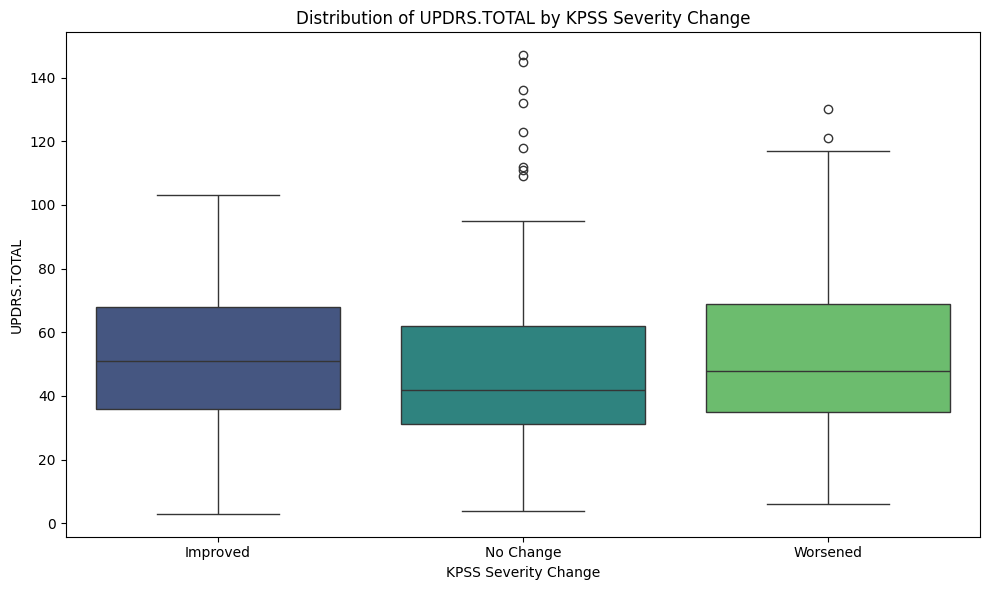

'Uso.Levodopa' column not found in df_analysis.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de estilo
sns.set(style="whitegrid")

# ---------------------------------------------------------
# 1. Impacto del Sexo en el Cambio de Dolor (Categórica vs Categórica)
# ---------------------------------------------------------
if 'Sexo' in df_analysis.columns:
    plt.figure(figsize=(10, 6))

    # Countplot: Cuenta cuántos hombres/mujeres hay en cada categoría de cambio
    sns.countplot(data=df_analysis.dropna(subset=['Sexo', 'KPSS_Severity_Change']),
                  x='KPSS_Severity_Change',
                  hue='Sexo',
                  palette='viridis',
                  order=['Improved', 'No Change', 'Worsened']) # Orden lógico para facilitar lectura

    plt.title('Cambio en Severidad del Dolor según Sexo', fontsize=14)
    plt.xlabel('Evolución del Dolor', fontsize=12)
    plt.ylabel('Número de Pacientes', fontsize=12)
    plt.legend(title='Sexo')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Variable 'Sexo' no encontrada.")

# ---------------------------------------------------------
# 2. Relación con Severidad Motora (Numérica vs Categórica)
# ---------------------------------------------------------
if 'UPDRS.TOTAL' in df_analysis.columns:
    plt.figure(figsize=(10, 6))

    # Boxplot: Muestra la distribución del puntaje motor para cada grupo
    sns.boxplot(data=df_analysis.dropna(subset=['UPDRS.TOTAL', 'KPSS_Severity_Change']),
                x='KPSS_Severity_Change',
                y='UPDRS.TOTAL',
                palette='viridis',
                order=['Improved', 'No Change', 'Worsened'])

    plt.title('Distribución de Carga Motora (UPDRS) según Evolución del Dolor', fontsize=14)
    plt.xlabel('Evolución del Dolor', fontsize=12)
    plt.ylabel('Puntaje UPDRS Total (Basal)', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Variable 'UPDRS.TOTAL' no encontrada.")

# ---------------------------------------------------------
# 3. Impacto del Tratamiento con Levodopa (Categórica vs Categórica)
# ---------------------------------------------------------
if 'Uso.Levodopa' in df_analysis.columns:
    plt.figure(figsize=(10, 6))

    sns.countplot(data=df_analysis.dropna(subset=['Uso.Levodopa', 'KPSS_Severity_Change']),
                  x='KPSS_Severity_Change',
                  hue='Uso.Levodopa',
                  palette='viridis',
                  order=['Improved', 'No Change', 'Worsened'])

    plt.title('Cambio en Severidad del Dolor según Uso de Levodopa', fontsize=14)
    plt.xlabel('Evolución del Dolor', fontsize=12)
    plt.ylabel('Número de Pacientes', fontsize=12)
    plt.legend(title='Uso de Levodopa')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Variable 'Uso.Levodopa' no encontrada.")

/tmp/ipython-input-3877530172.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis.dropna(subset=['UPDRS.TOTAL', 'KPSS_Severity_Change']),


Columns in df_analysis:
['reg.innn', 'KPSS Severity_first', 'KPSS Severity_last', 'UPDRS.TOTAL', 'PDQ8.index', 'PDQ39.mov.index', 'PDQ39.daily.index', 'PDQ39.Emotion.index', 'PDQ39.stigma.index', 'PDQ39.social.index', 'PDQ39.cogni.index', 'PDQ39.comm.index', 'PDQ39.discom.index', 'PDQ39.SI.index', 'severity_first_numeric', 'severity_last_numeric', 'KPSS_Severity_Change']
Skipping Sex vs KPSS Severity Change plot: 'Sexo' column not found.


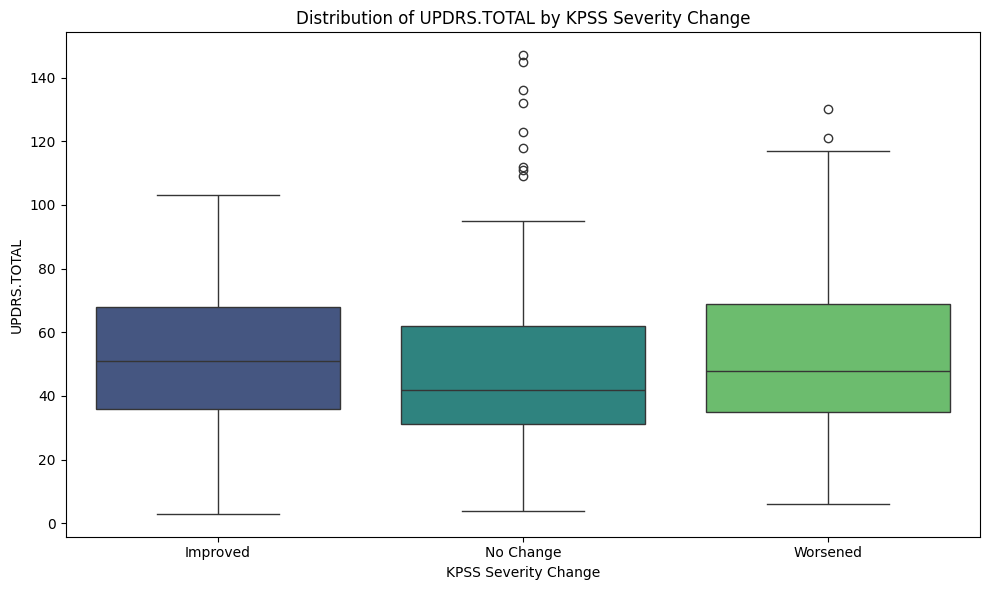

Skipping Levodopa Usage vs KPSS Severity Change plot: 'Uso.Levodopa' column not found.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Auditoría de Columnas Disponibles
# Imprimimos la lista para confirmar visualmente qué variables sobrevivieron al merge anterior.
print("Columns in df_analysis:")
print(df_analysis.columns.tolist())

# ---------------------------------------------------------
# 2. Visualización: Impacto del Sexo (Si está disponible)
# ---------------------------------------------------------
if 'Sexo' in df_analysis.columns:
    plt.figure(figsize=(10, 6))
    # Countplot: Ideal para comparar frecuencias entre grupos categóricos
    sns.countplot(data=df_analysis.dropna(subset=['Sexo', 'KPSS_Severity_Change']),
                  x='KPSS_Severity_Change',
                  hue='Sexo',
                  palette='viridis',
                  order=['Improved', 'No Change', 'Worsened'])
    plt.title('Cambio en Severidad KPPS según Sexo')
    plt.ylabel('Cantidad de Pacientes')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipped: La columna 'Sexo' no se encontró en el dataset.")

# ---------------------------------------------------------
# 3. Visualización: Impacto Motor (UPDRS Total)
# ---------------------------------------------------------
if 'UPDRS.TOTAL' in df_analysis.columns:
    plt.figure(figsize=(10, 6))
    # Boxplot: Muestra la distribución de una variable numérica (UPDRS) a través de grupos categóricos
    sns.boxplot(data=df_analysis.dropna(subset=['UPDRS.TOTAL', 'KPSS_Severity_Change']),
                x='KPSS_Severity_Change',
                y='UPDRS.TOTAL',
                palette='viridis',
                order=['Improved', 'No Change', 'Worsened'])
    plt.title('Distribución de Carga Motora (UPDRS) según Cambio en Dolor')
    plt.ylabel('Puntaje UPDRS Total')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipped: La columna 'UPDRS.TOTAL' no se encontró.")

# ---------------------------------------------------------
# 4. Visualización: Impacto de Medicación (Levodopa)
# ---------------------------------------------------------
if 'Uso.Levodopa' in df_analysis.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_analysis.dropna(subset=['Uso.Levodopa', 'KPSS_Severity_Change']),
                  x='KPSS_Severity_Change',
                  hue='Uso.Levodopa',
                  palette='viridis',
                  order=['Improved', 'No Change', 'Worsened'])
    plt.title('Cambio en Severidad KPPS según Uso de Levodopa')
    plt.ylabel('Cantidad de Pacientes')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipped: La columna 'Uso.Levodopa' no se encontró.")